In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
%env JAX_TRACEBACK_FILTERING=off
import jax
jax.config.update('jax_traceback_filtering', 'off')


env: JAX_TRACEBACK_FILTERING=off


In [4]:
from sprint.icl_sfc_utils import Circuitizer

In [5]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [7]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

fatal: destination path 'data/itv' already exists and is not an empty directory.


In [8]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task_name = "antonyms"

task = tasks[task_name]

# print(len(task))

task = {
    k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
}

print(len(task))

pairs = list(task.items())

batch_size = 8 
n_shot=16
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

143


In [9]:
layers = list(range(1, 17))
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)

Setting up masks...
Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/16 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
grads_through_attn = []
grads_through_ff = []
masks = list(circuitizer.masks.keys())
for layer in layers:
    grad_through_attns = {}
    for mask_target in masks:
        masked_grad = circuitizer.grad_mid[layer] * circuitizer.masks[mask_target][..., None] / circuitizer.masks[mask_target].mean()
        grad_through_attn = circuitizer.grad_through_attn(layer, masked_grad)
        for mask_source in masks:
            grad_through_attns[(mask_source, mask_target)] = float(circuitizer.mask_average((grad_through_attn * (circuitizer.resids_pre[layer] * circuitizer.masks[mask_source][..., None])).sum(-1), mask_source))
    grads_through_attn.append(grad_through_attns)
    grad_through_ffs = {}
    for mask in masks:
        masked_grad = circuitizer.grad_pre[layer+1] * circuitizer.masks[mask][..., None]
        mlp_out = circuitizer.resids_pre[layer+1] - circuitizer.resids_mid[layer]
        grad_through_ffs[mask] = float(circuitizer.mask_average((masked_grad * mlp_out).sum(-1), mask))
    grads_through_ff.append(grad_through_ffs)

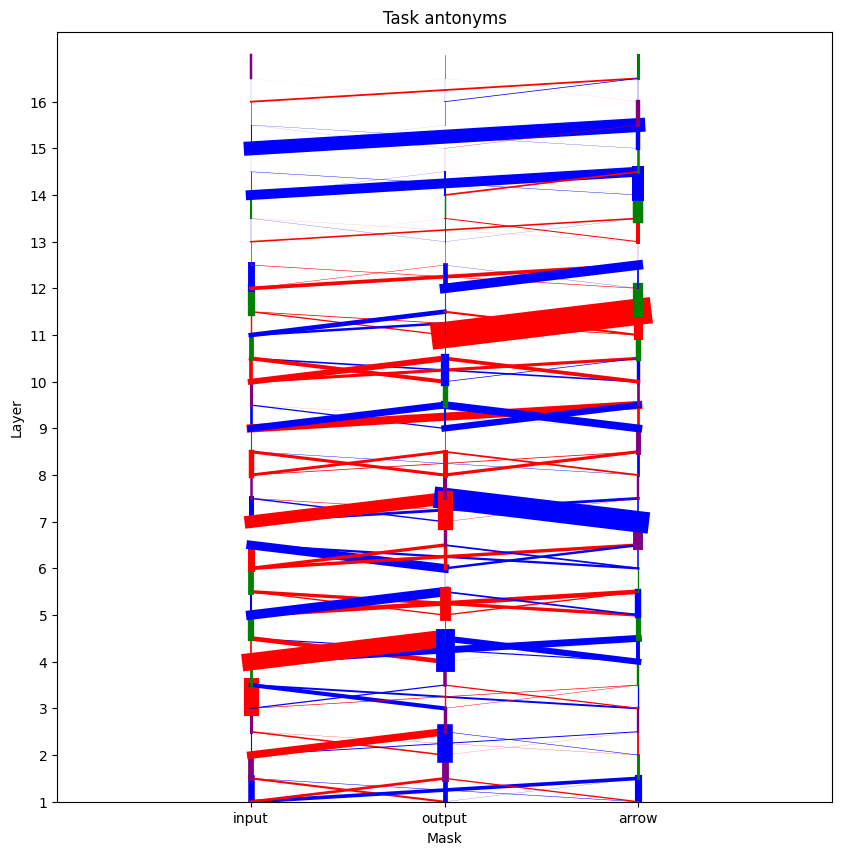

In [11]:
from matplotlib import pyplot as plt
import numpy as np
# masks_ = ["input", "output", "arrow", "newline"]
# masks_ = ["prompt", "input", "output", "arrow", "newline"]
masks_ = ["input", "output", "arrow"]
plt.figure(figsize=(10, 10))
plt.title(f"Task {task_name}")
plt.xlim((0, len(masks_) + 1))
plt.ylim(layers[0] * 2, layers[-1] * 2 + 3)
plt.xticks(range(1, len(masks_) + 1), masks_)
plt.yticks(np.arange(layers[0] * 2, layers[-1] * 2 + 2, 2), layers)
plt.ylabel("Layer")
plt.xlabel("Mask")
for layer, grad_through_attn, grad_through_ff in zip(layers, grads_through_attn, grads_through_ff):
    for (mask_source, mask_target), effect in grad_through_attn.items():
        if mask_source not in masks_ or mask_target not in masks_:
            continue
        # width = max(0, np.log(np.abs(effect) * len(masks) + 1e-12) + 12) * 1
        width = np.abs(effect) * 5e3
        if not np.isfinite(width) or width < 0:
            continue
        plt.plot([masks_.index(mask_source) + 1, masks_.index(mask_target) + 1], [layer * 2, layer * 2 + 1], color="blue" if effect < 0 else "red", linewidth=width)
    for mask, effect in grad_through_ff.items():
        if mask not in masks_:
            continue
        # width = max(0, np.log(np.abs(effect) + 1e-12) + 6) * 4
        width = np.abs(effect) * 5e1
        if not np.isfinite(width) or width < 0:
            continue
        plt.plot([masks_.index(mask) + 1, masks_.index(mask) + 1], [layer * 2 + 1, layer * 2 + 2], color="purple" if effect < 0 else "green", linewidth=width)
plt.show()